# Régularisation

Nous avons vu, tout au long de ce cours sur le deep learning, que les réseaux de neurones sont très performants pour résoudre tout type de problèmes. Il y a cependant quelques problèmes majeurs qui limitent le potentiel de nos réseaux. Le problème que nous allons adresser ici est l'*overfitting*. 

L'*overfitting*, c'est quand le modèle s'adapte trop précisement aux données d'entrainement en capturant les moindres anomalies et bruits ce qui va entraîner une mauvaise performance sur les données de test. 

<img src="images/overfitting.png" alt="overfitting" width="800"/>

Ce problème est courant lors de l'entraînement des réseaux de neurones. C'est pour surveiller ce phénomène au cours de l'entraînement que l'on utilise un dataset de validation que l'on va évaluer régulièrement pour vérifier que le loss décroit bien. Dans un cas d'*overfitting*, nos courbes de training et validation vont ressembler à cela :  

<img src="images/overfittingcurve.png" alt="overfittingcurve" width="500"/>

Le *loss* de training continue de diminuer tandis que le *loss* de validation augmente : cela traduit un apprentissage des spécificités des données de training ce qui est l'inverse de ce que l'on veut en entraînant notre réseau.  

Si on y réflechit bien, c'est un comportement tout à fait logique de l'optimisation : le modèle va tout faire pour diminuer le *loss* sur les données d'entraînement.

Il s'agit d'un élément très important à considérer lors de l'entraînement d'un réseau de neurones.   
Pour lutter contre ce problème, plusieurs techniques ont été proposées et nous allons en présenter deux ici en essayant de comprendre intuitivement pourquoi ces méthodes fonctionnent.  

Ces deux méthodes sont la **régularisation-L2** et le ***dropout***. Ce notebook s'inspire du [cours de fastai](https://github.com/fastai/fastbook/tree/master).

## Régularisation-L2

La régularisation L2 est une technique très simple qui consiste à ajouter la somme des poids au carré à notre fonction de loss (avec un facteur $wd$ appelé *weight_decay*). Ce terme dans la fonction de *loss* va encourager les poids à être le plus petit possible. 

### Pourquoi ça réduit l'overfitting ? 

Intuitivement, on peut imaginer que des poids plus importants vont conduire à des pente plus abruptes dans la fonction de *loss*.  
Pour confirmer notre intuition, on peut regarder ce qu'il se passe sur la fonction parabole :  
$y=a \times x²$   

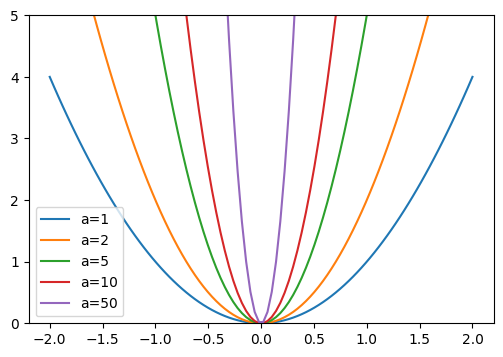

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(6,4))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Plus $a$ augmente, plus la parabole devient abrupte. Si on fait l'analogie entre $a$ et nos poids, on peut imaginer que des poids importants vont conduire à une fonction representé par un réseau ayant des changements abruptes ce qui peut correspondre à de l'*overfitting*. 

Cette justification peut sembler un peu "magique" mais en pratique, la régularisation-L2 va vraiment avoir un impact positif pour la prévention de l'*overfitting*. 

Il faut aussi ajouter que limiter la valeur des poids va également limiter la capacité d'apprentissage du réseau globalement mais cette limitation permet d'arriver à une meilleure généralisation et donc d'éviter l'*overfitting*.

### Implémentation de la méthode

Pour implémenter la régularisation-l2, on peut le faire manuellement en ajoutant le terme à notre *loss* :   
$L(w) = L_0(w) + wd \sum_{i=1}^{n} w_i^2$ où $L(w)$ est la perte régularisée, $L_0(w)$ est la fonction de perte classique, $wd$ (*weight_decay*) est le coefficient de régularisation et $w_i$ est un poids du modèle.     
ou  ```loss_regu = loss + wd * (parameters**2).sum()``` en python.

Plus simplement, il est possible de l'utiliser en pytorch en ajoutant la paramètre *weight_decay* dans l'initialisaton de l'optimizer (par défaut fixé à 0).  
Par exemple : 

In [ ]:
import torch
params=torch.tensor([1.0], requires_grad=True)
# Pour SGD
torch.nn.optim.SGD(params, lr=0.1, weight_decay=0.1)
# Pour Adam
torch.nn.optim.Adam(params, lr=0.1, weight_decay=0.1)

Si votre modèle a des problèmes d'*overfitting*, c'est une méthode à tester !

## Dropout

Le *dropout* est une méthode de régularisation qui a été introduite dans le papier [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580). L'idée est simple et consiste à changer aléatoirement une partie des activations du réseau à zéro à chaque étape de l'entraînement. De cette manière, chaque neurone devient nécessaire pour sortir un *output* cohérent en fonction de l'*input*. 

<img src="images/dropout.png" alt="dropout" width="600"/>


### Intuition 

Pour comprendre comment fonctionne le dropout, on peut reprendre une métaphore de l'auteur du papier (le fameux Geoffrey Hinton) : 

*Je suis allé à ma banque. Les guichetiers changeaient constamment et j'ai demandé à l'un d'eux pourquoi. Il m'a dit qu'il ne savait pas, mais qu'ils étaient souvent déplacés. J'ai pensé que cela devait être parce que cela nécessiterait la coopération entre les employés mettre en place une fraude bancaire et donc que cela limite énormement les possibilités de le faire. Cela m'a fait réaliser que retirer aléatoirement un sous-ensemble différent de neurones à chaque exemple empêcherait les conspirations et ainsi réduirait le surapprentissage.*

Cela va empêcher les neurones de frauder, c'est à dire de trouver un raccourci frauduleux pour une prédiction (on pourrait supposer que chaque neurone se base sur un détail de l'entrée uniquement pour faire sa prédiction).  

Cette méthode va pousser les neurones à coopérer et va également augmenter le bruit dans les activations ce qui conduit à un modèle plus robuste. On peut aussi voir le *dropout* comme une mixture d'un grand nombre de modèles plus petits qui vont coopérer lors de la phase de test.



### Implémentation

On peut implémenter le dropout de cette manière en python :  

In [4]:
import torch.nn as nn
class Dropout(nn.Module):
  def __init__(self, p): 
    self.p = p
  def forward(self, x):
    # Le droupout n'est appliqué que pendant l'entrainement
    if not self.training: 
      return x
    # On crée un masque de dropout à partir d'une distribution de Bernoulli
    mask = torch.zeros_like(x)
    mask.bernoulli_(1 - self.p) # chaque élément a une probabilité de 1-p d'être mis à 0 sinon il est mis à 1
    # On applique le masque et on divise par 1-p pour garder une moyenne cohérente
    return x * mask/(1-self.p)

La couche est également déjà implémenté en pytorch et on peut l'utiliser avec [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) qui prend en paramètre $p$ la probabilité qu'une activation soit mise à zéro.   

**Note** :  Lors de l'utilisation du *dropout* de pytorch, il faut bien faire attention à passer le modèle en mode train pendant l'entrainement et eval pendant la validation/test (comme avec la *batchnorm*).   
On peut le faire avec 
```model.train()``` et ```model.eval()```.